<a href="https://colab.research.google.com/github/hhaemin/smart_healthcare/blob/main/ESG_VGG%EA%B5%AC%ED%98%84(%EC%88%98%EC%97%85%EC%9A%A9)_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG CNN(Convolution Neural Network) 구현하기 with keras

In [1]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.9.2


In [2]:
!pip install tensorflow_gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 16 kB/s 
     |████████████████████████████████| 438 kB 58.0 MB/s 
     |████████████████████████████████| 1.7 MB 61.4 MB/s 
     |████████████████████████████████| 5.9 MB 57.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully u

# Image Classification Using VGG - Cat or Dog Kaggle Competition

![catanddog](https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg)

* 출처 : kaggle competitions(dogs vs cats)

##### * [Cat of Dog Kaggel competition](https://www.kaggle.com/c/dogs-vs-cats/overview/description)를 이용한 이미지 분류 프로젝트.
##### * VGG16 모델을 이용하여 학습
##### * VGG-16 paper : proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)”.
##### * patrick013 code

In [3]:
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers, activations
import numpy as np
import os, random
import matplotlib.pyplot as plt
print(tf.__version__)

2.10.0


## Prepare Data

Dataset
* training set : 25,000 이미지
* testing set : 12,500 이미지
* class : dogs, cats
Since uploading the dataset to google colab is time-consuming.


In [4]:
! git clone https://github.com/patrick013/Image-Classification-CNN-and-VGG.git

Cloning into 'Image-Classification-CNN-and-VGG'...
remote: Enumerating objects: 37510, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 37510 (delta 43), reused 36 (delta 7), pack-reused 37414
Receiving objects: 100% (37510/37510), 812.51 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Checking out files: 100% (50016/50016), done.


In [18]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=64
def get_pathframe(path):
  '''
  Get all the images paths and its corresponding labels
  Store them in pandas dataframe
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('.')[0]
    if category == 'dog':
      categories.append(1)
    else:
      categories.append(0)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

In [19]:
df=get_pathframe("Image-Classification-CNN-and-VGG/dataset/dataset/")
df.tail(5)

,filename,category,paths
24995,cat.6264.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24996,cat.3219.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24997,dog.3151.jpg,1,Image-Classification-CNN-and-VGG/dataset/datas...
24998,cat.8780.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...
24999,cat.1338.jpg,0,Image-Classification-CNN-and-VGG/dataset/datas...


In [20]:
def load_and_preprocess_image(path):
  '''
  Load each image and resize it to desired shape
  '''
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
  image /= 255.0  # normalize to [0,1] range
  return image

def convert_to_tensor(df):
  '''
  Convert each data and labels to tensor
  '''
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_image)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

In [21]:
X,Y=convert_to_tensor(df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <MapDataset element_spec=TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)>
Shape of Y in data: <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [22]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(22500)
dataset_test=dataset.skip(22500)

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

<BatchDataset element_spec=(TensorSpec(shape=(64, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int64, name=None))>

### Check Images

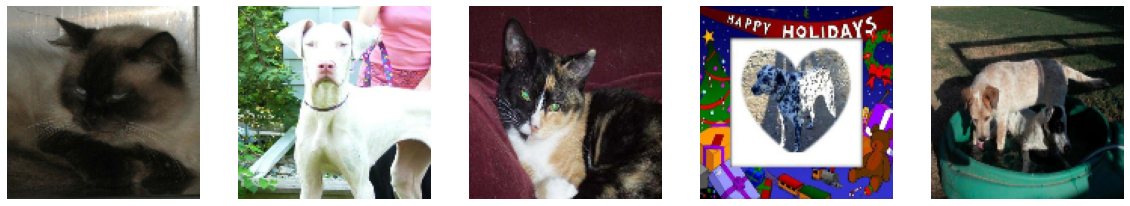

In [23]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

##### tesorflow conv2D 형태 예시
```
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
)
```

## Convolutional Neural Networks - VGGNet
### Build Network


In [25]:
def VGG16():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(64,3,strides=1, padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(64,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

  model.add(layers.Conv2D(128,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(128,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

  model.add(layers.Conv2D(256,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(256,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(256,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

  model.add(layers.Conv2D(512,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(512,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(512,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

  model.add(layers.Conv2D(512,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(512,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.Conv2D(512,3,strides=1, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation(activations.relu))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=2, padding="same"))

  model.add(layers.Flatten())
  model.add(layers.Dense(4096, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4096, activation="relu"))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1, activation="softmax")) #Dense 10이지만, Input Class가 1이기 때문에 1로 설정

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [26]:
model=VGG16()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 64)      0

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Training

### Evaluation

## VGG16 API 활용


In [27]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

vggmodel = tf.keras.models.Model(pre_trained_model.input, x)

vggmodel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

vggmodel.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

### Training

In [28]:
vgghist=vggmodel.fit_generator(dataset_train,epochs=20,validation_data=dataset_test)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


351/351 [==============================] - 91s 216ms/step - loss: 0.4708 - accuracy: 0.7655 - val_loss: 0.2862 - val_accuracy: 0.8738
Epoch 2/20
351/351 [==============================] - 79s 222ms/step - loss: 0.2869 - accuracy: 0.8792 - val_loss: 0.2278 - val_accuracy: 0.9030
Epoch 3/20
351/351 [==============================] - 78s 218ms/step - loss: 0.2460 - accuracy: 0.8970 - val_loss: 0.2043 - val_accuracy: 0.9079
Epoch 4/20
351/351 [==============================] - 78s 217ms/step - loss: 0.2193 - accuracy: 0.9080 - val_loss: 0.1827 - val_accuracy: 0.9239
Epoch 5/20
351/351 [==============================] - 76s 213ms/step - loss: 0.2010 - accuracy: 0.9170 - val_loss: 0.1763 - val_accuracy: 0.9255
Epoch 6/20
351/351 [==============================] - 78s 217ms/step - loss: 0.1897 - accuracy: 0.9228 - val_loss: 0.1605 - val_accuracy: 0.9331
Epoch 7/20
351/351 [==============================] - 76s 211ms/step - loss: 0.1778 - accuracy: 0.9282 - val_loss: 0.1612 - val_accuracy: 0.9

### Evaluation
